In [1]:
import sys
import matplotlib.pyplot as plt
 
# Avoid AttributeError: module 'sqlalchemy' has no attribute 'orm'
import sqlalchemy.orm  # noqa: F401

sys.path.append("..")
from gmo_hft_bot.db.database import initialize_database
from gmo_hft_bot.db import crud
from backtest.visualize.ohlcv import ohlcv_plot
from backtest.utils.utils import get_ohlcv_df, get_predict_df, match_timestamp_for_ohlcv
from backtest.backtest_trade.richman_backtest import richman_backtest
from backtest.visualize.backtest_visualize import cum_return_plot, position_change_plot, position_change_average_plot


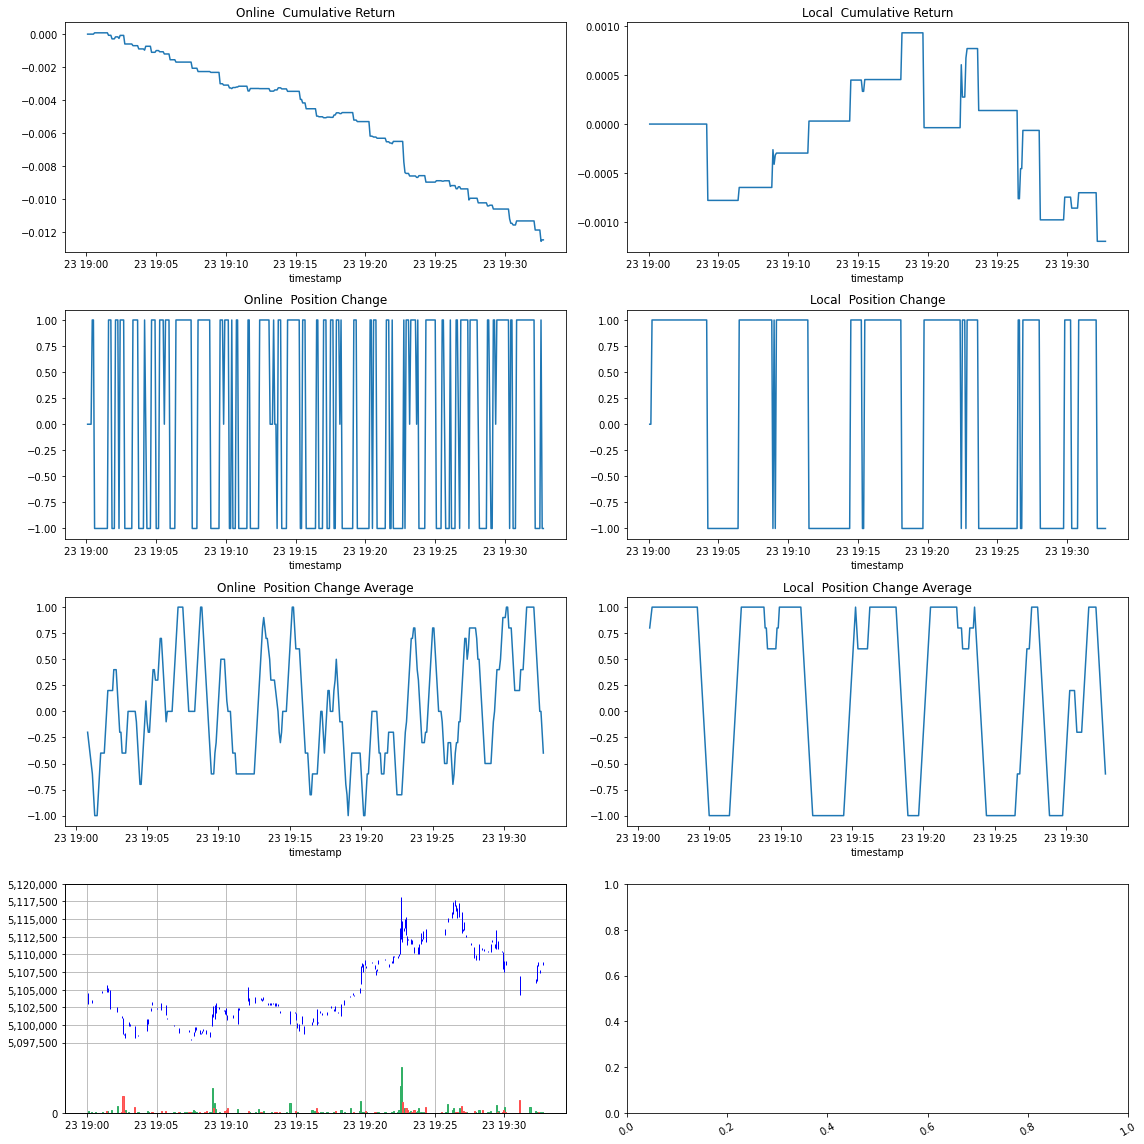

In [2]:
symbol = "BTC_JPY"

_, SessionLocal = initialize_database(uri="sqlite:///../example.db")
with SessionLocal() as db:
    ohlcv_data = crud.get_ohlcv_with_symbol(db=db, symbol=symbol)
    predict_data = crud.get_predict_items(db=db, symbol=symbol)

# fig, axes = plt.subplots(2, 1, figsize=(16, 8))
# axes = axes.flatten()

time_span = 5
ohlcv_df = get_ohlcv_df(ohlcv_data, time_span=time_span)
buy_df, sell_df = get_predict_df(predict_data)
timestamped_buy_df = match_timestamp_for_ohlcv(ohlcv_df, buy_df, time_span)
timestamped_sell_df = match_timestamp_for_ohlcv(ohlcv_df, sell_df, time_span)
result_online = richman_backtest(ohlcv_df, buy_df=timestamped_buy_df, sell_df=timestamped_sell_df)

# local data backtest
local_timestamped_buy_df = timestamped_buy_df.copy()
local_timestamped_sell_df = timestamped_sell_df.copy()
pips = 1000
local_timestamped_buy_df['price'] = ohlcv_df.loc[:,'close'] - pips
local_timestamped_sell_df['price'] = ohlcv_df.loc[:,'close'] + pips
result_local = richman_backtest(ohlcv_df, buy_df=local_timestamped_buy_df, sell_df=local_timestamped_sell_df)

_, ax = plt.subplots(4, 2, figsize=(16, 16))
ax = ax.flatten()
cum_return_plot(ax[0], result_online["cumulative_return"], 'Online')
cum_return_plot(ax[1], result_local["cumulative_return"], 'Local')
position_change_plot(ax[2], result_online["position"], 'Online')
position_change_plot(ax[3], result_local["position"], 'Local')
position_change_average_plot(ax[4], result_online["position"], 'Online')
position_change_average_plot(ax[5], result_local["position"], 'Local')
ohlcv_plot(ax[6], ohlcv_df)
plt.tight_layout()
plt.show()


In [3]:
pips = 500
ohlcv_df["local_buy_price"] = ohlcv_df["close"] - pips
merged_buy_df = timestamped_buy_df.merge(ohlcv_df["local_buy_price"], right_index=True, left_index=True)
merged_buy_df["subt_online_local"] = merged_buy_df["price"] - merged_buy_df["local_buy_price"]
merged_buy_df[['price', "local_buy_price", "subt_online_local"]].tail(30)

,price,local_buy_price,subt_online_local
timestamp,,,
2022-03-23 19:30:20+00:00,5107578.0,5107239.0,339.0
2022-03-23 19:30:25+00:00,5109202.0,5107958.0,1244.0
2022-03-23 19:30:30+00:00,5108878.0,5108435.0,443.0
2022-03-23 19:30:35+00:00,5108535.0,5108435.0,100.0
2022-03-23 19:30:40+00:00,5107872.0,5108435.0,-563.0
2022-03-23 19:30:45+00:00,5106959.0,5108435.0,-1476.0
2022-03-23 19:30:50+00:00,5107410.0,5108435.0,-1025.0
2022-03-23 19:30:55+00:00,5107918.0,5106601.0,1317.0
2022-03-23 19:31:00+00:00,5107291.0,5106601.0,690.0


In [5]:
ohlcv_df.tail(40)

,open,high,low,close,volume,local_buy_price
timestamp,,,,,,
2022-03-23 19:29:30+00:00,5110802.0,5111867.0,5110802.0,5110800.0,0.08,5110300.0
2022-03-23 19:29:35+00:00,5110800.0,5110834.0,5110749.0,5110800.0,0.18,5110300.0
2022-03-23 19:29:40+00:00,5110800.0,5110800.0,5110800.0,5110800.0,0.00,5110300.0
2022-03-23 19:29:45+00:00,5110800.0,5110800.0,5110800.0,5110800.0,0.00,5110300.0
2022-03-23 19:29:50+00:00,5110506.0,5110506.0,5110412.0,5110313.0,0.08,5109813.0
2022-03-23 19:29:55+00:00,5110313.0,5110313.0,5108000.0,5109107.0,0.28,5108607.0
2022-03-23 19:30:00+00:00,5109107.0,5109107.0,5107519.0,5109107.0,0.64,5108607.0
2022-03-23 19:30:05+00:00,5109107.0,5109107.0,5108449.0,5107961.0,0.08,5107461.0
2022-03-23 19:30:10+00:00,5107961.0,5107961.0,5107961.0,5107739.0,0.02,5107239.0


In [7]:
index_unique_counts = ohlcv_df.index.value_counts()
1 in [1.0]

True